In [2]:
# Import Necessary Libiraries
import os
import numpy as np
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import img_to_array, load_img

#Loading the best fit model
from keras.models import load_model

In [ ]:
import tensorflow as tf; print(tf.__version__)

2.12.0


In [ ]:
# Checking whether the GPU Device is selected or not

%tensorflow_version 2.x
#tf library for deep learning
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))


# Data Understanding

In [4]:
# connect google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = "/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/data/train"
test_dir  = "/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/data/test"

In [6]:
len(train_dir)

64

In [ ]:
os.listdir(train_dir+"/NuNuHlaing")

['Nu Nu Hlaing_train_face19 (1).jpg',
 'Nu Nu Hlaing_train_face20 (1).jpg',
 'Nu Nu Hlaing_train_face196.jpg',
 'Nu Nu Hlaing_train_face198.jpg',
 'Nu Nu Hlaing_train_face197.jpg',
 'Nu Nu Hlaing_train_face199.jpg',
 'Nu Nu Hlaing_train_face59 (1).jpg',
 'Nu Nu Hlaing_train_face65 (1).jpg',
 'Nu Nu Hlaing_train_face66 (1).jpg',
 'Nu Nu Hlaing_train_face67 (1).jpg',
 'Nu Nu Hlaing_train_face0.jpg',
 'Nu Nu Hlaing_train_face1 (1).jpg',
 'Nu Nu Hlaing_train_face2 (1).jpg',
 'Nu Nu Hlaing_train_face3 (1).jpg',
 'Nu Nu Hlaing_train_face4 (1).jpg',
 'Nu Nu Hlaing_train_face5 (1).jpg',
 'Nu Nu Hlaing_train_face6 (1).jpg',
 'Nu Nu Hlaing_train_face7 (1).jpg',
 'Nu Nu Hlaing_train_face8 (1).jpg',
 'Nu Nu Hlaing_train_face9 (1).jpg',
 'Nu Nu Hlaing_train_face10 (1).jpg',
 'Nu Nu Hlaing_train_face11 (1).jpg',
 'Nu Nu Hlaing_train_face50.jpg',
 'Nu Nu Hlaing_train_face52.jpg',
 'Nu Nu Hlaing_train_face100.jpg',
 'Nu Nu Hlaing_train_face101.jpg',
 'Nu Nu Hlaing_train_face132.jpg',
 'Nu Nu Hlaing_tr

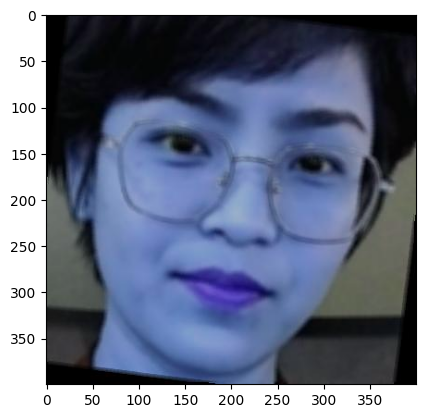

In [ ]:
import cv2
image = cv2.imread(train_dir+"/NuNuHlaing"+"/Nu Nu Hlaing_train_face (4).jpg")

import matplotlib.pyplot as plt   #matplotlib is good for map and chart
plt.imshow(image)

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

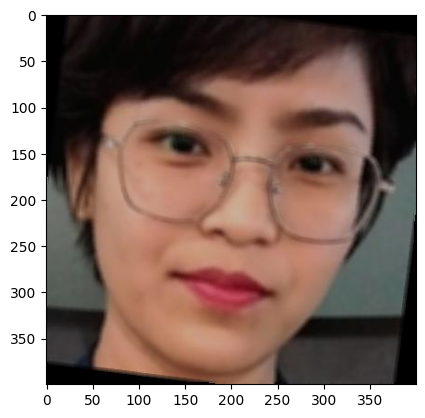

In [ ]:
plt.imshow(image_rgb)

# Data Preprocessing

In [123]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the Haar Cascade classifier
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/haarcascades/haarcascade_frontalface_default.xml')


In [121]:
def detect_resize_normalize(input_image, target_size=(400, 400)):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the input image
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    print(f'Number of detected faces: {len(faces)}')

    normalized_faces = []  # List to store normalized faces

    # Loop over all detected faces
    if len(faces) > 0:
        for i, (x, y, w, h) in enumerate(faces):
            # Crop the face region
            face = input_image[y:y + h + 15, x:x + w + 15]

            # Create a new image with grey background
            grey_background = np.ones_like(face) * 128

            # Get the dimensions of the face region
            face_height, face_width, _ = face.shape

            # Calculate the position to paste the face on the grey background
            paste_x = (grey_background.shape[1] - face_width) // 2
            paste_y = (grey_background.shape[0] - face_height) // 2

            # Paste the face on the grey background
            grey_background[paste_y:paste_y + face_height, paste_x:paste_x + face_width] = face

            # Resize the face to the target size
            resized_face = cv2.resize(grey_background, target_size)

            # Normalize the pixel values to the range [0, 1]
            normalized_face = resized_face.astype(np.float32) / 255.0

            normalized_faces.append(normalized_face)

    return normalized_faces


In [105]:
# All images will be rescaled by 1./255.
datagen_train = ImageDataGenerator( rescale = 1.0/255. )
datagen_test = ImageDataGenerator( rescale = 1.0/255. )

batch_size = 10

train_generator = datagen_train.flow_from_directory(train_dir,
                                            target_size = (50,100),
                                            #color_mode="grayscale",
                                             batch_size = batch_size,
                                            class_mode = "categorical",
                                            shuffle = True)
test_generator = datagen_test.flow_from_directory(test_dir,
                                       target_size = (50,100),
                                       #color_mode="grayscale",
                                       batch_size = batch_size,
                                       class_mode = "categorical",
                                       shuffle = False)



Found 936 images belonging to 3 classes.
Found 234 images belonging to 3 classes.


In [8]:
train_generator.class_indices

{'AngelinaJolie': 0, 'NuNuHlaing': 1, 'WillSmith': 2}

In [9]:
train_generator.n

936

# Modeling (CNN)

In [106]:
# Convolutional Neural Network
cnn_model  = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(50,100,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [107]:
cnn_model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics =['acc'])

In [108]:
cnn_model.fit(train_generator, epochs = 30, verbose = 2, shuffle  = False)

Epoch 1/30
94/94 - 28s - loss: 0.5938 - acc: 0.7340 - 28s/epoch - 300ms/step
Epoch 2/30
94/94 - 26s - loss: 0.0250 - acc: 0.9893 - 26s/epoch - 278ms/step
Epoch 3/30
94/94 - 26s - loss: 2.9397e-04 - acc: 1.0000 - 26s/epoch - 279ms/step
Epoch 4/30
94/94 - 26s - loss: 4.9931e-05 - acc: 1.0000 - 26s/epoch - 274ms/step
Epoch 5/30
94/94 - 26s - loss: 2.3855e-05 - acc: 1.0000 - 26s/epoch - 278ms/step
Epoch 6/30
94/94 - 26s - loss: 1.4686e-05 - acc: 1.0000 - 26s/epoch - 278ms/step
Epoch 7/30
94/94 - 27s - loss: 9.4451e-06 - acc: 1.0000 - 27s/epoch - 282ms/step
Epoch 8/30
94/94 - 30s - loss: 7.1524e-06 - acc: 1.0000 - 30s/epoch - 323ms/step
Epoch 9/30
94/94 - 34s - loss: 5.0912e-06 - acc: 1.0000 - 34s/epoch - 362ms/step
Epoch 10/30
94/94 - 27s - loss: 3.8868e-06 - acc: 1.0000 - 27s/epoch - 289ms/step
Epoch 11/30
94/94 - 27s - loss: 3.1794e-06 - acc: 1.0000 - 27s/epoch - 288ms/step
Epoch 12/30
94/94 - 26s - loss: 2.4207e-06 - acc: 1.0000 - 26s/epoch - 281ms/step
Epoch 13/30
94/94 - 26s - loss: 1

## Evaluation

In [ ]:
# Class Labels
class_dictionary = test_generator.class_indices
print('Labels dictionary',class_dictionary)

Labels dictionary {'AngelinaJolie': 0, 'NuNuHlaing': 1, 'WillSmith': 2}


In [109]:
y_predicted = cnn_model.predict(test_generator) # A way to predict data

24/24 [==============================] - 2s 84ms/step


In [110]:
for i in y_predicted:
  print(i)
  print(np.argmax(i))
  print()

[9.9999994e-01 6.1041417e-15 1.2221008e-18]
0

[9.9999994e-01 9.7317881e-16 1.6502438e-15]
0

[9.99999940e-01 1.01615716e-10 2.43460552e-13]
0

[9.99999940e-01 1.01615716e-10 2.43460552e-13]
0

[9.9999994e-01 9.5659009e-16 1.3326493e-14]
0

[9.9999994e-01 9.5659009e-16 1.3326493e-14]
0

[9.9999970e-01 1.1751267e-09 2.6849224e-07]
0

[9.9999970e-01 1.1751267e-09 2.6849224e-07]
0

[1.0000000e+00 2.5590797e-15 9.6921071e-13]
0

[1.0000000e+00 2.5590797e-15 9.6921071e-13]
0

[9.9999994e-01 1.2772636e-12 2.7383659e-13]
0

[9.9999994e-01 6.1041417e-15 1.2221008e-18]
0

[9.9999994e-01 1.2772636e-12 2.7383659e-13]
0

[9.9999994e-01 3.1545789e-19 4.3798583e-15]
0

[9.9999994e-01 3.1545789e-19 4.3798583e-15]
0

[9.9999994e-01 6.0152878e-14 5.5759782e-11]
0

[9.9999994e-01 6.0152878e-14 5.5759782e-11]
0

[9.9999994e-01 6.2020859e-16 1.8756662e-14]
0

[1.0000000e+00 6.2020869e-16 1.8756664e-14]
0

[9.9999952e-01 5.4933991e-09 4.2154758e-07]
0

[9.9999946e-01 5.4933986e-09 4.2154753e-07]
0

[9.9999

In [111]:
y_pred = []
for i in y_predicted:
  print(i)
  print(type(i))
  print(np.argmax(i))
  y_pred.append(np.argmax(i))

[9.9999994e-01 6.1041417e-15 1.2221008e-18]
<class 'numpy.ndarray'>
0
[9.9999994e-01 9.7317881e-16 1.6502438e-15]
<class 'numpy.ndarray'>
0
[9.99999940e-01 1.01615716e-10 2.43460552e-13]
<class 'numpy.ndarray'>
0
[9.99999940e-01 1.01615716e-10 2.43460552e-13]
<class 'numpy.ndarray'>
0
[9.9999994e-01 9.5659009e-16 1.3326493e-14]
<class 'numpy.ndarray'>
0
[9.9999994e-01 9.5659009e-16 1.3326493e-14]
<class 'numpy.ndarray'>
0
[9.9999970e-01 1.1751267e-09 2.6849224e-07]
<class 'numpy.ndarray'>
0
[9.9999970e-01 1.1751267e-09 2.6849224e-07]
<class 'numpy.ndarray'>
0
[1.0000000e+00 2.5590797e-15 9.6921071e-13]
<class 'numpy.ndarray'>
0
[1.0000000e+00 2.5590797e-15 9.6921071e-13]
<class 'numpy.ndarray'>
0
[9.9999994e-01 1.2772636e-12 2.7383659e-13]
<class 'numpy.ndarray'>
0
[9.9999994e-01 6.1041417e-15 1.2221008e-18]
<class 'numpy.ndarray'>
0
[9.9999994e-01 1.2772636e-12 2.7383659e-13]
<class 'numpy.ndarray'>
0
[9.9999994e-01 3.1545789e-19 4.3798583e-15]
<class 'numpy.ndarray'>
0
[9.9999994e-01

In [112]:
y_test = test_generator.classes.tolist()
y_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [113]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print('confusion_matrix')
print(confusion_matrix)

confusion_matrix
[[78  0  0]
 [ 0 93  0]
 [ 6  0 57]]


In [114]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print('Accuracy Score :',accuracy_score(y_test,y_pred)*100,'%')
print('Precision Macro Score : ',precision_score(y_test,y_pred,average = 'macro')*100,'%')
print('Recall_Score :',recall_score(y_test,y_pred, average = 'macro')*100,'%')
print('F1_Score :',f1_score(y_test,y_pred, average = 'macro')*100,'%')

Accuracy Score : 97.43589743589743 %
Precision Macro Score :  97.61904761904762 %
Recall_Score : 96.82539682539682 %
F1_Score : 97.09876543209876 %


# Save Model File

In [136]:
cnn_model.save('/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/model/smartattendance.h5')

In [137]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/model/smartattendance.h5')


In [138]:
y_predicted_with_loaded_model = loaded_model.predict(test_generator) # A way to predict data

24/24 [==============================] - 3s 125ms/step


In [139]:
y_predicted_with_loaded_model

array([[9.99999940e-01, 6.10414166e-15, 1.22210083e-18],
       [9.99999940e-01, 9.73178811e-16, 1.65024380e-15],
       [9.99999940e-01, 1.01615716e-10, 2.43460552e-13],
       [9.99999940e-01, 1.01615716e-10, 2.43460552e-13],
       [9.99999940e-01, 9.56590094e-16, 1.33264930e-14],
       [9.99999940e-01, 9.56590094e-16, 1.33264930e-14],
       [9.99999702e-01, 1.17512666e-09, 2.68492244e-07],
       [9.99999702e-01, 1.17512666e-09, 2.68492244e-07],
       [1.00000000e+00, 2.55907966e-15, 9.69210714e-13],
       [1.00000000e+00, 2.55907966e-15, 9.69210714e-13],
       [9.99999940e-01, 1.27726356e-12, 2.73836590e-13],
       [9.99999940e-01, 6.10414166e-15, 1.22210083e-18],
       [9.99999940e-01, 1.27726356e-12, 2.73836590e-13],
       [9.99999940e-01, 3.15457889e-19, 4.37985829e-15],
       [9.99999940e-01, 3.15457889e-19, 4.37985829e-15],
       [9.99999940e-01, 6.01528782e-14, 5.57597822e-11],
       [9.99999940e-01, 6.01528782e-14, 5.57597822e-11],
       [9.99999940e-01, 6.20208

# Validation

In [119]:
op = dict(zip(train_generator.class_indices.values(), train_generator.class_indices.keys()))

Number of detected faces: 1
1/1 [==============================] - 0s 308ms/step
The image is of AngelinaJolie


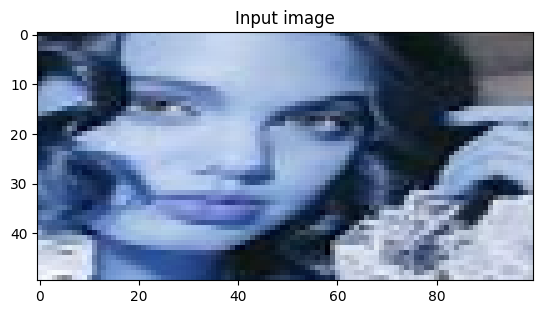

In [130]:
path = "/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/Dataset/Angelina Jolie/096_75710434.jpg"

# Load and process the input image using detect_resize_normalize function
img = cv2.imread(path)
normalized_faces = detect_resize_normalize(img, target_size=(100, 50))  # Note the target_size change

# Process each normalized face and make predictions
for normalized_face in normalized_faces:
    input_arr = np.array([normalized_face])

    pred = np.argmax(cnn_model.predict(input_arr))

    print(f'The image is of {op[pred]}')

    # Display the image
    plt.imshow(normalized_face, cmap='gray')  # Assuming the normalized face is in grayscale
    plt.title("Input image")
    plt.show()

Number of detected faces: 1
1/1 [==============================] - 0s 29ms/step


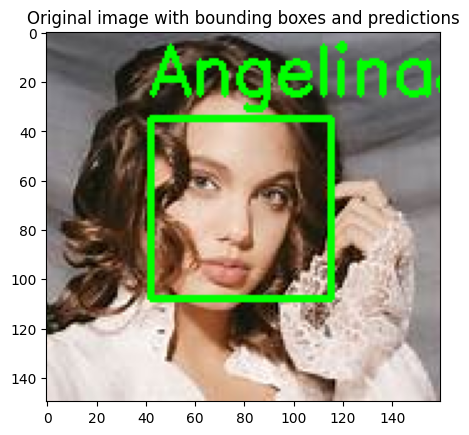

In [134]:
path = "/content/drive/MyDrive/Smart Attendance (CV-Batch-7 )/Dataset/Angelina Jolie/096_75710434.jpg"

# Load and process the input image using detect_resize_normalize function
img = cv2.imread(path)
normalized_faces = detect_resize_normalize(img, target_size=(100, 50))  # Note the target_size change
# Convert the input image to grayscale for face detection
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Process each normalized face and make predictions
for normalized_face in normalized_faces:
    # Resize the normalized face to match the expected input shape of your model
    resized_face = cv2.resize(normalized_face, (100, 50))

    # Add a batch dimension
    input_arr = np.expand_dims(resized_face, axis=0)

    pred = np.argmax(cnn_model.predict(input_arr))
    pred_label = op[pred]  # Assuming op contains class labels

    # Find the coordinates of the detected face in the grayscale image
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=4)

    # Iterate through detected faces and draw bounding boxes
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, pred_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the original image with bounding boxes and predicted labels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image with bounding boxes and predictions")
plt.show()